In [1]:
import sys
sys.path.append('/Users/admin/Desktop/tesi/Thesis/')
from skimage.filters import gaussian
from handcrafted_descriptors.descriptor import binary_gabor_features as bgf
import import_ipynb
from handcrafted_descriptors.gabor_classification import utility as utility 
import numpy as np 
from matplotlib import pyplot as plt

importing Jupyter notebook from /Users/admin/Desktop/tesi/Thesis/handcrafted_descriptors/gabor_classification/utility.ipynb


In [2]:
species = ['Arthonia_radiata','Caloplaca_cerina','Candelariella_reflexa','Candelariella_xanthostigma','Chrysothrix_candelaris','Flavoparmelia_caperata','Gyalolechia_flavorubescens','Hyperphyscia_adglutinata'
        ,'Lecanora_argentata','Lecanora_chlarotera','Lecidella_elaeochroma','Melanelixia_glabratula'
        ,'Phaeophyscia_orbicularis','Physcia_biziana','Physconia_grisea','Ramalina_farinacea','Ramalina_fastigiata','Xanthomendoza_fallax','Xanthomendoza_fulva','flavoparmenia_soredians']


In [7]:
def from_rgb_to_opponent(im_r,im_g, im_b):
    o1 = np.zeros((im_r.shape[0],im_r.shape[1]))
    o2 = np.zeros((im_r.shape[0],im_r.shape[1]))
    o3 = np.zeros((im_r.shape[0],im_r.shape[1]))
    
    
    
    for i in range(im_r.shape[0]):
        for j in range(im_r.shape[1]):
            o1[i,j] = (im_r[i,j] - im_g[i,j])/(np.sqrt(2))
            o2[i,j] = (im_r[i,j] + im_g[i,j] - 2*im_b[i,j])/((np.sqrt(6)))
            o3[i,j] = (im_r[i,j] + im_g[i,j] + im_b[i,j])/(np.sqrt(3))
    return o1,o2,o3

In [8]:
def getDescriptors(img, halflength = 15):
    img_r = img[:,:,0]
    img_g = img[:,:,1]
    img_b = img[:,:,2]

    o1,o2,o3 = from_rgb_to_opponent(img_r,img_g,img_b)

    feat_1 = bgf.BGF(o1, 200,200,50, halflngt = halflength, all = True)
    feat_2 = bgf.BGF(o2, 200,200,50, halflngt = halflength, all = True)
    feat_3 = bgf.BGF(o3, 200,200,50, halflngt = halflength, all = True)
    res = np.concatenate([feat_1, feat_2, feat_3])
    return res 

In [9]:
def extract_descriptors(path,hlf,train = True, specs = species):
    images_pth, label_dict = utility.getPath_and_dict(path, train)
    print(len(images_pth))
    descriptor_list = [] 
    train_labels = []
    image_count = len(images_pth) 
    for i,img_path in enumerate(images_pth):
        cl = img_path.split('/')[-2]
        class_index = species.index(cl)
        train_labels.append(class_index)        
        img = utility.readimage(img_path)
        dsc = getDescriptors(img, halflength = hlf)
        if(i%200==0):
            print(dsc.shape)
        descriptor_list.append(dsc)     
    descriptors =np.array(descriptor_list)
    train_labels = np.array(train_labels)
    return descriptors, train_labels, images_pth

## MAIN ---> BINARY GABOR FEATURE

In [18]:
feat,lab,_ = extract_descriptors('../../../data_2/train', hlf = 4)
feat = feat.reshape((1200,648))
print('end training')
test_feat, test_lab,image_list = extract_descriptors('../../../data_2/valid', hlf = 4, train = False)
test_feat = test_feat.reshape((400,648))


1200


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in ubyte_scalars
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in ubyte_scalars
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in ubyte_scalars
  if sys.path[0] == '':


(648, 1)
(648, 1)
(648, 1)
(648, 1)
(648, 1)
(648, 1)
end training
400
(648, 1)
(648, 1)


In [19]:
np.save('feat_opp_4_2.npy', feat)    # .npy extension is added if not given
np.save('lab_opp_4_2.npy', lab)
np.save('test_feat_opp_4_2.npy', test_feat)
np.save('test_lab_opp_4_2.npy', test_lab)

In [20]:
svm ,score_rbf = utility.search_for_best_rbf(feat, lab, test_feat, test_lab)

Best estimator found by grid search :  SVC(C=100.0, gamma=1)
Accuracy score : 0.9525


(0.833988470407062, 0.8348857832988269, 0.8123238711650046)

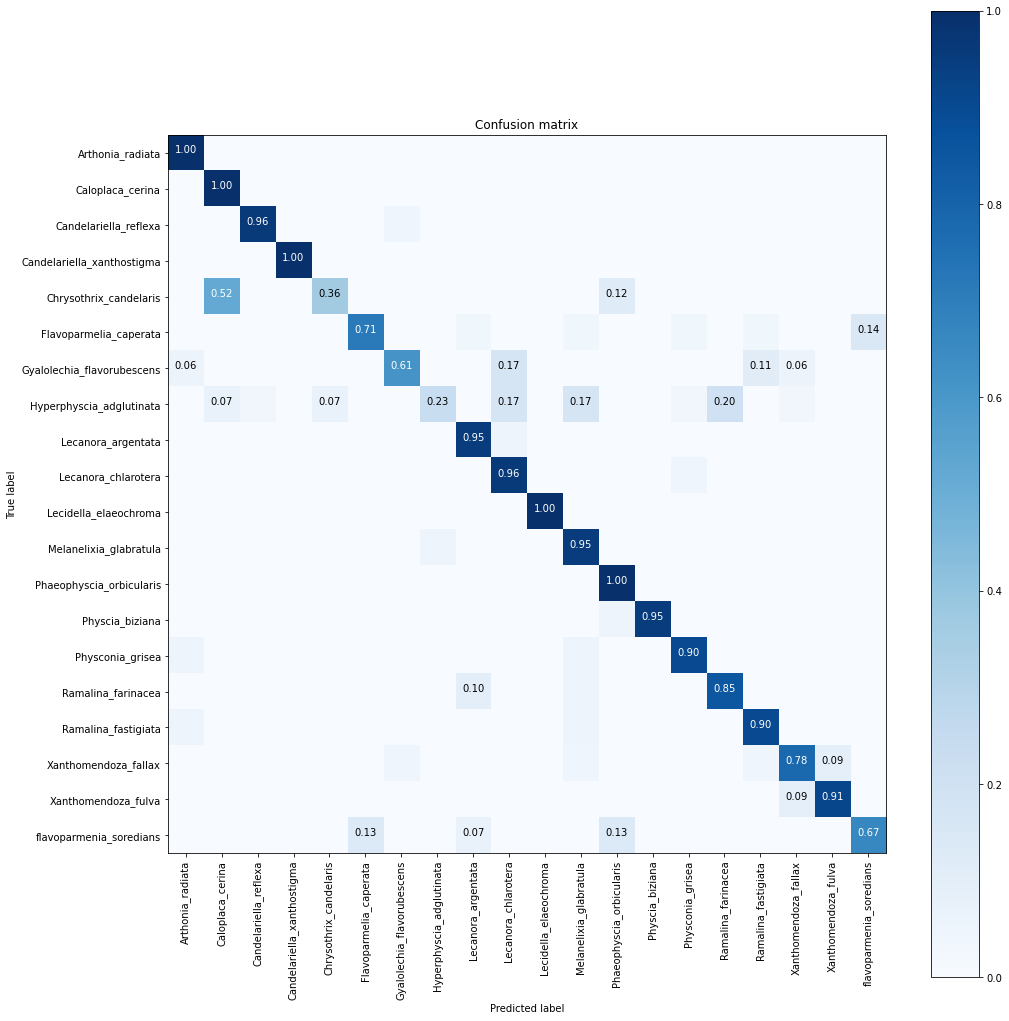

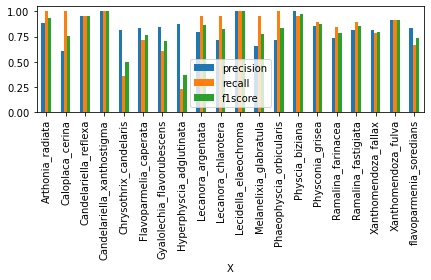

In [12]:
halfln = 5
director_cm = 'results/results_bgp/confusion_matrix/'
name_cm = 'OOOnewcm_'+ str(halfln)
pred = utility.create_and_save_confusion_matrix(svm, test_feat, test_lab, species, director_cm, name_cm)

director_pra = 'results/results_bgp/pra/'
name_pra = 'newpra_' + str(halfln)
utility.calculate_and_plot_precision_recall(test_lab, pred, species, director_pra, name_pra)